#EDA для данных клиентов Т-инвестиций

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/datasets/invest_db.csv', sep = ';')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Первый взгляд

Сначала посмотрим, как выглядят случайные 5 строк набора данных:

In [ ]:
df.sample(5)

,id,date,age,education_level_cd,marital_status_cd,children_cnt,monthly_income_amt,invest_utilization_dt,forts_flg,margin_status_flg,...,portf_fnd_amt,portf_opt_amt,portf_ore_amt,ccr_balance_amt,cor_balance_amt,lon_balance_amt,posts,comments,reacts,reads
23114,782576591,2024-04-09,64,NaN,WID,"0,0",NaN,2021-11-11,0,0,...,"98,0","0,0","0,0",NaN,"3,0",NaN,"0,0","0,0","0,0","0,0"
283569,524689593,2024-02-26,42,GRD,UNM,"0,0","3782,0",2023-01-30,0,0,...,"637,0","0,0","0,0",NaN,"184,0","0,0","0,0","0,0","0,0","1,0"
259752,2055240489,2024-04-21,33,NaN,NaN,"0,0","0,0",2021-10-22,1,1,...,"133,0","0,0","0,0",NaN,"316,0",NaN,"0,0","0,0","0,0","0,0"
230565,1128861892,2024-04-02,22,NaN,UNM,"0,0",NaN,2023-01-29,1,0,...,"231,0","0,0","0,0","0,0","10328,0","0,0","0,0","0,0","0,0","0,0"
130716,1386380669,2024-03-18,50,NaN,NaN,"0,0","2215,0",2022-12-06,0,0,...,"0,0","0,0","402,0","0,0","93,0",NaN,"0,0","0,0","0,0","0,0"


Видим, что есть множество пропущенных значений, и в целом датафрейм очень широкий.

## Изменение типа данных

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458370 entries, 0 to 458369
Data columns (total 51 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   id                        458370 non-null  int64 
 1   date                      458370 non-null  object
 2   age                       458370 non-null  int64 
 3   education_level_cd        233460 non-null  object
 4   marital_status_cd         267030 non-null  object
 5   children_cnt              410310 non-null  object
 6   monthly_income_amt        355140 non-null  object
 7   invest_utilization_dt     458370 non-null  object
 8   forts_flg                 458370 non-null  int64 
 9   margin_status_flg         458370 non-null  int64 
 10  qualified_investor_flg    458370 non-null  int64 
 11  in_payment_rub_amt        458370 non-null  object
 12  out_payment_rub_amt       458370 non-null  object
 13  uncovered_position_amt    458370 non-null  object
 14  turn

Больше половины колонок имеют неправильный тип данных(object вместо float или int). Исправим:

In [89]:
normal_cols = ['id' , 'date', 'age', 'education_level_cd', 'marital_status_cd', 'invest_utilization_dt', 'forts_flg', 'margin_status_flg', 'qualified_investor_flg']

for col in df.columns:
  if col in normal_cols or df[col].dtypes != 'object': continue

  df[col] = df[col].str.replace(',', '.').astype('float64')

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458370 entries, 0 to 458369
Data columns (total 51 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        458370 non-null  int64  
 1   date                      458370 non-null  object 
 2   age                       458370 non-null  int64  
 3   education_level_cd        233460 non-null  object 
 4   marital_status_cd         267030 non-null  object 
 5   children_cnt              410310 non-null  float64
 6   monthly_income_amt        355140 non-null  float64
 7   invest_utilization_dt     458370 non-null  object 
 8   forts_flg                 458370 non-null  int64  
 9   margin_status_flg         458370 non-null  int64  
 10  qualified_investor_flg    458370 non-null  int64  
 11  in_payment_rub_amt        458370 non-null  float64
 12  out_payment_rub_amt       458370 non-null  float64
 13  uncovered_position_amt    458370 non-null  f

## Обработка пропущенных значений

Посмотрим на долю null-значений в столбцах с хотя бы одним пропуском:

In [91]:
nulls = df.loc[:, df.isna().any()]

Text(0.5, 1.0, 'Доля NULL значений в столбцах с пропусками')

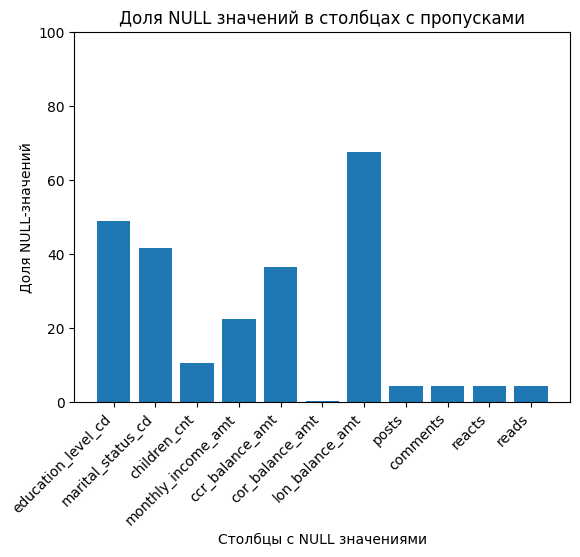

In [92]:
plt.bar(nulls.isnull().sum().index, nulls.isnull().sum()/len(nulls)*100)

plt.ylim(0, 100)
plt.xticks(rotation=45, ha = "right")

plt.xlabel("Столбцы с NULL значениями")
plt.ylabel("Доля NULL-значений")
plt.title('Доля NULL значений в столбцах с пропусками')

Так как в некоторых столбцах есть более 30% пропусков, то целесообразно было бы заполнить NULL-значения случайно из уже имеющихся:

In [93]:
for col in nulls.columns:
  non_null = df[col].dropna()
  random_val = np.random.choice(non_null, size = df[col].isna().sum(), replace=True)
  df.loc[df[col].isna(), col] = random_val

## Распределения переменных

Посмотрим на распределения основных переменных

### Возраст

Возраст пользователей:

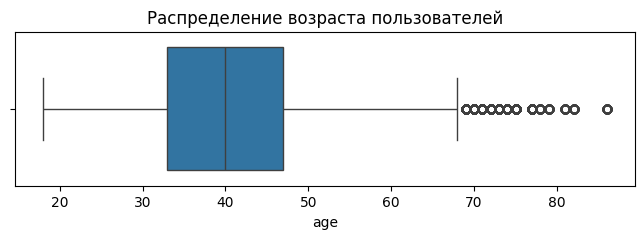

In [212]:
fig = plt.figure(figsize=(8, 2))
sns.boxplot(df['age'], orient="h")
plt.title("Распределение возраста пользователей")
plt.show()

Более подробно:

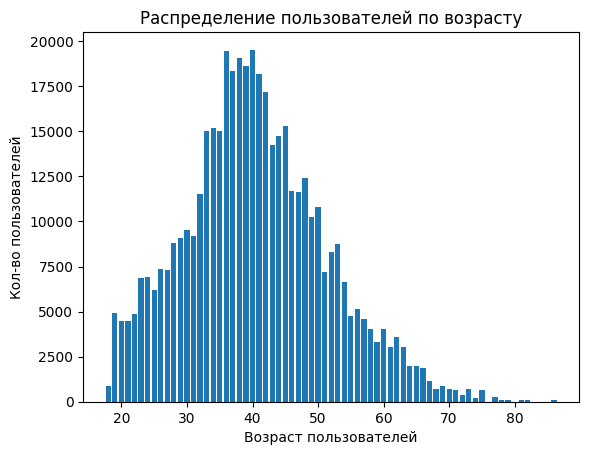

In [237]:
vc = df['age'].value_counts()
plt.bar(vc.index, vc.values)
plt.ylabel("Кол-во пользователей")
plt.xlabel("Возраст пользователей")
plt.title("Распределение пользователей по возрасту")
plt.show()

Видим, что половина аудитории - пользователи от 33 до 47 лет.

##### Сохраним результат

In [136]:
results = []
results.append(fig)

### Уровень образования, семейный статус, кол-во детей

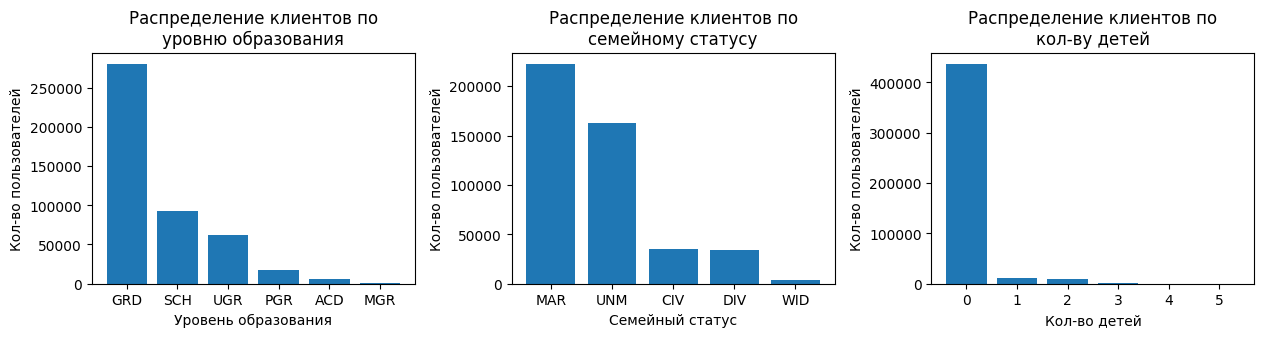

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (15, 3))
plt.subplots_adjust(wspace = 0.3)

col_names = ['education_level_cd', 'marital_status_cd', 'children_cnt']
titles = ['уровню образования', 'семейному статусу', 'кол-ву детей']
x_label = ['Уровень образования', 'Семейный статус', 'Кол-во детей']

for i in range(len(col_names)):
  axes[i].bar(df[col_names[i]].value_counts().index, df[col_names[i]].value_counts().values)
  axes[i].set_title(f'Распределение клиентов по\n{titles[i]}')
  axes[i].set_xlabel(x_label[i])
  axes[i].set_ylabel("Кол-во пользователей")

Из кадого графика можно сделать выводы, что большая часть аудитории:
1. люди со средними/высшим образованием;
2. женатые/неженатые люди;
3. бездетные.

А среди пользователей с детьми больше всего людей с 1-2 детьми:

Text(0, 0.5, 'Кол-во пользователей')

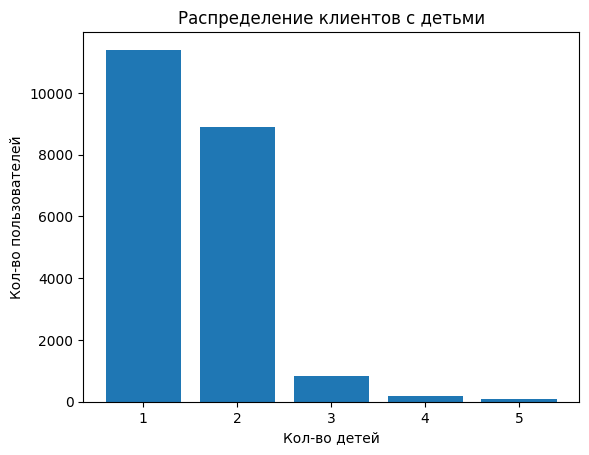

In [238]:
plt.bar(df[df['children_cnt']>0]['children_cnt'].value_counts().index, df[df['children_cnt']>0]['children_cnt'].value_counts().values)
plt.title("Распределение клиентов с детьми")
plt.xlabel("Кол-во детей")
plt.ylabel("Кол-во пользователей")

### Флаги: срочный рынок, маржинальная торговля, квал. инвестор

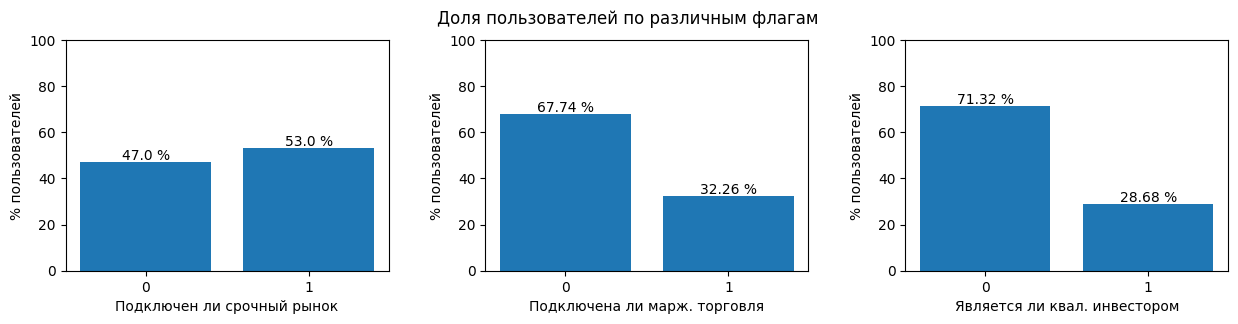

In [197]:
fig, axes = plt.subplots(1, 3, figsize = (15, 3))
plt.subplots_adjust(wspace=0.3)

fig.suptitle("Доля пользователей по различным флагам")
col_names = ['forts_flg', 'margin_status_flg', 'qualified_investor_flg']
x_label = ['Подключен ли срочный рынок', 'Подключена ли марж. торговля', 'Является ли квал. инвестором']

for i in range(len(col_names)):
  vc = df[col_names[i]].value_counts()
  axes[i].bar(vc.index, vc.values/len(df)*100)
  axes[i].set_xlabel(x_label[i])
  axes[i].set_ylabel("% пользователей")
  axes[i].set_ylim(0, 100)
  axes[i].set_xticks([0, 1])

  for j in range(len(vc.index)):
      axes[i].text(j, vc[j]*100/len(df) + 1, f'{round(vc[j]*100/len(df), 2)} %', ha='center')

Видим, что чуть больше, чем у половины пользователей подключен срочный рынок; у трети пользователей подключена маржинальная торговля; а 28% пользователей - квалифицированные инвесторы.

##### Сохраним результат

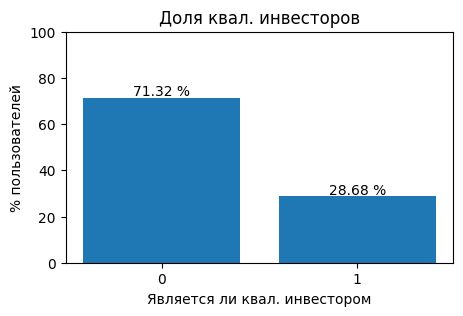

In [218]:
vc = df[col_names[i]].value_counts()

fig = plt.figure(figsize=(5, 3))
plt.bar(vc.index, vc.values/len(df)*100)
plt.xlabel(x_label[i])
plt.ylabel("% пользователей")
plt.ylim(0, 100)
plt.title("Доля квал. инвесторов")
plt.xticks([0, 1])

for j in range(len(vc.index)):
    plt.text(j, vc[j]*100/len(df) + 1, f'{round(vc[j]*100/len(df), 2)} %', ha='center')

results.append(fig)

### Дата использования первого счета в инвестициях

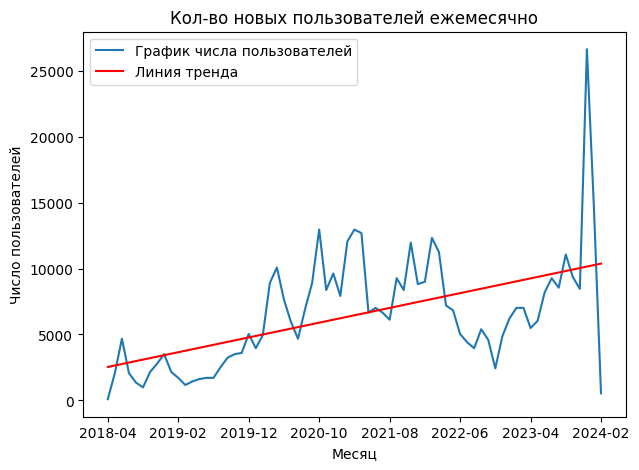

In [220]:
new_users_monthly = df['invest_utilization_dt'].str[:7].reset_index().groupby('invest_utilization_dt').agg({'index': 'count'})

fig = plt.figure(figsize=(7, 5))

plt.plot(new_users_monthly, label = "График числа пользователей")

x = np.arange(len(new_users_monthly))
y = new_users_monthly.values
k, b = np.polyfit(x, y, 1)
plt.plot(x, k*x + b, color='red', label = "Линия тренда")

plt.ylabel("Число пользователей")
plt.xlabel("Месяц")
plt.title("Кол-во новых пользователей ежемесячно")
plt.xticks([i*10 for i in range(len(new_users_monthly)//10+1)])
plt.legend()
plt.show()

*Резкое падание в феврале 2024 года связано с тем, что данные хранят сведения по 01.02.2024.*

В общем виден растущий тренд на кол-во новых пользователей.

##### Сохраним результат

In [221]:
results.append(fig)

### Кол-во постов, комментариев, реакций, прочтений

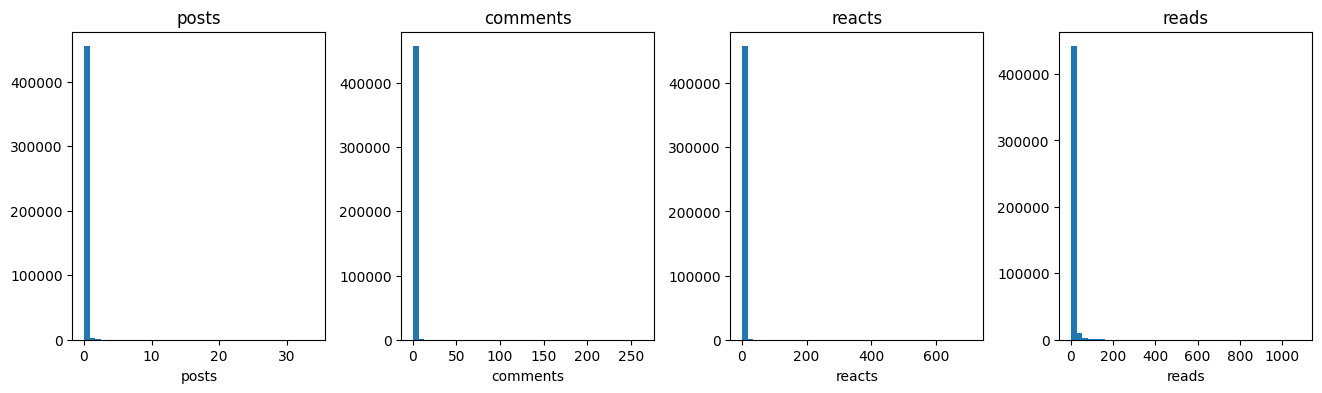

In [68]:
cols = ['posts', 'comments', 'reacts', 'reads']

fig, axes = plt.subplots(1, len(cols),  figsize = (16, 4))
plt.subplots_adjust(wspace=0.3)

for i in range(len(cols)):
  axes[i].hist(df[df[cols[i]]>-1][cols[i]], bins = 40)
  axes[i].set_title(cols[i])
  axes[i].set_xlabel(cols[i])

Почти все пользователи не проявляют активность в соц. сети Т-инвестиций. Уберем пользователей с нулевой активностью и посмотрим на график еще раз:

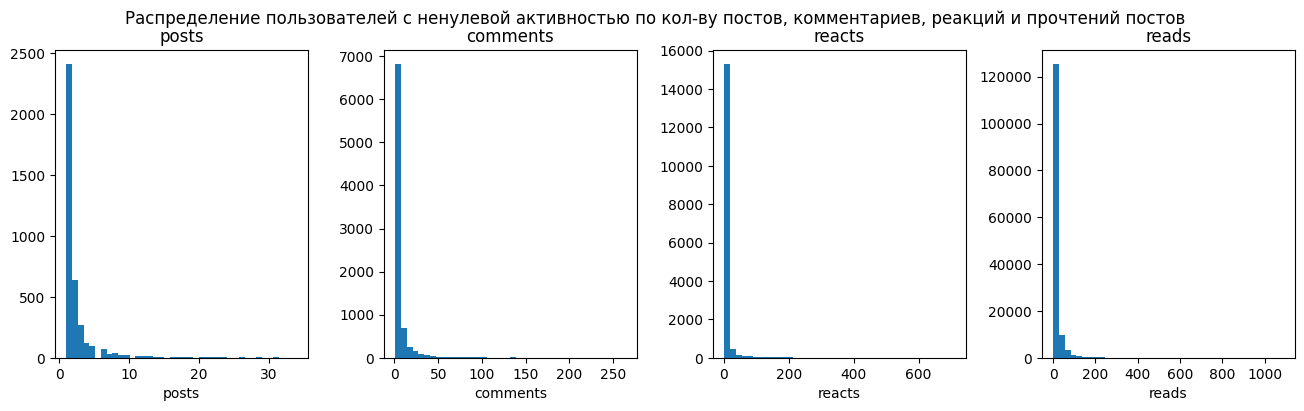

In [157]:
cols = ['posts', 'comments', 'reacts', 'reads']

fig, axes = plt.subplots(1, len(cols),  figsize = (16, 4))
plt.subplots_adjust(wspace=0.3)
plt.suptitle("Распределение пользователей с ненулевой активностью по кол-ву постов, комментариев, реакций и прочтений постов")

for i in range(len(cols)):
  axes[i].hist(df[df[cols[i]]!=0][cols[i]], bins = 40)
  axes[i].set_title(cols[i])
  axes[i].set_xlabel(cols[i])

Картина изменилась, но несильно.

Посмотрим на эти данные в цифрах:

In [239]:
for col in cols:
  print(f"{col}: {round(len(df[df[col]>0])/len(df)*100, 2)}%")

posts: 0.83%
comments: 1.8%
reacts: 3.56%
reads: 30.87%


Менее 1% пользователей написали хотя бы один пост; около 2% - комментарий; 3,5% пользователей ставили хотя бы одну реакцию; почти 31% прочитали хотя бы один пост.

##### Сохраним результат

In [159]:
results.append(fig)

### Сумма портфеля, суммы ввода и вывода

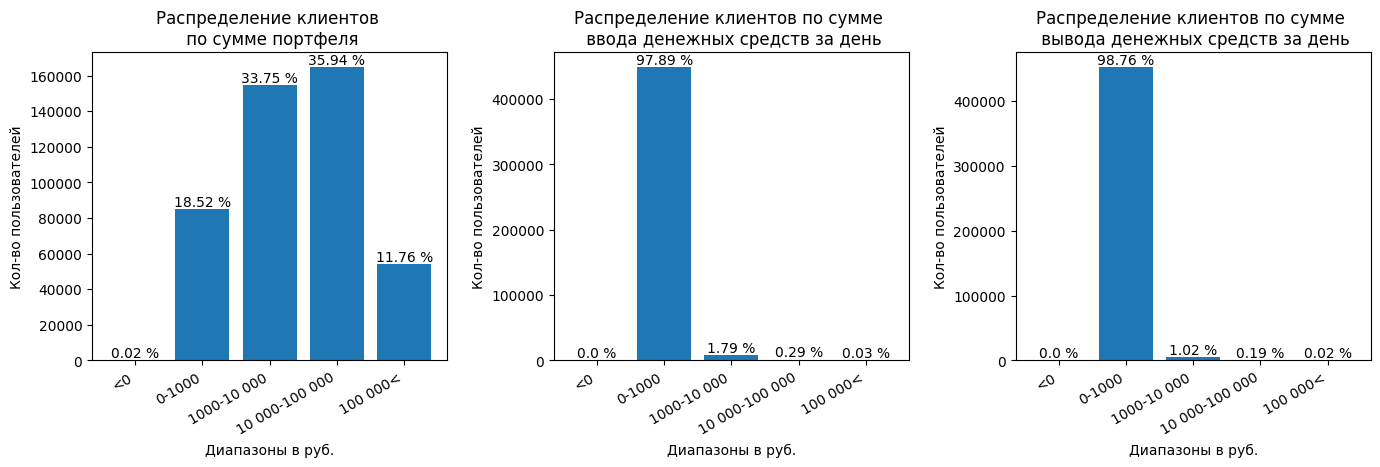

In [161]:
fig, axes = plt.subplots(1, 3, figsize = (16.5, 4))
plt.subplots_adjust(wspace=0.3)

groups = ['<0', '0-1000', '1000-10 000', '10 000-100 000', '100 000<']
cols = ['portf_total_amt', 'in_payment_rub_amt', 'out_payment_rub_amt']
positions = [j for j in range(len(groups))]
titles = ['Распределение клиентов \n по сумме портфеля', 'Распределение клиентов по сумме \n ввода денежных средств за день', 'Распределение клиентов по сумме \n вывода денежных средств за день']

for i in range(len(cols)):
  k1 = len(df[df[cols[i]] < 0][cols[i]])
  k2 = len(df[(0 <= df[cols[i]]) & (df[cols[i]] < 1000)][cols[i]])
  k3 = len(df[(1000 <= df[cols[i]]) & (df[cols[i]] < 10000)][cols[i]])
  k4 = len(df[(10000 <= df[cols[i]]) & (df[cols[i]] < 100000)][cols[i]])
  k5 = len(df[ 100000 < df[cols[i]]][cols[i]])
  counts = [k1, k2, k3, k4, k5]

  axes[i].bar(groups, counts)
  axes[i].set_ylabel('Кол-во пользователей')
  axes[i].set_xlabel('Диапазоны в руб.')
  axes[i].set_title(titles[i])

  for j in range(len(groups)):
    axes[i].text(j, counts[j] + max(counts)*0.01, f'{round(counts[j]*100/len(df), 2)} %', ha='center')

  axes[i].set_xticks(positions)
  axes[i].set_xticklabels(groups, rotation=30, ha = "right")


Примерно у 90% пользователей в портфеле лежит не более 100 000 тыс. руб.

##### Сохраним результат

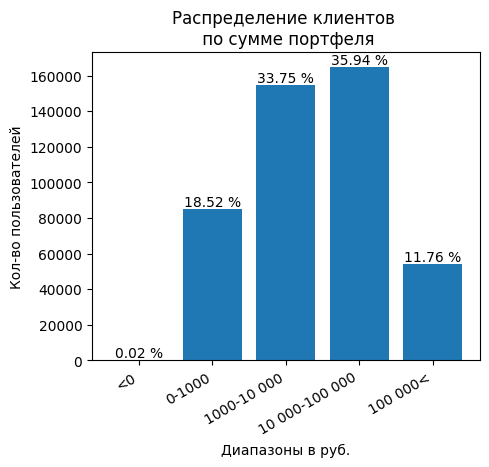

In [170]:
col = 'portf_total_amt'

k1 = len(df[df[col] < 0][col])
k2 = len(df[(0 <= df[col]) & (df[col] < 1000)][col])
k3 = len(df[(1000 <= df[col]) & (df[col] < 10000)][col])
k4 = len(df[(10000 <= df[col]) & (df[col] < 100000)][col])
k5 = len(df[ 100000 < df[col]][col])
counts = [k1, k2, k3, k4, k5]

fig = plt.figure(figsize = (5, 4))

plt.bar(groups, counts)
plt.ylabel('Кол-во пользователей')
plt.xlabel('Диапазоны в руб.')
plt.title(titles[0])

for j in range(len(groups)):
  plt.text(j, counts[j] + max(counts)*0.01, f'{round(counts[j]*100/len(df), 2)} %', ha='center')

plt.xticks(positions, groups, rotation=30, ha = "right")

results.append(fig)

## Корреляции переменных

Узнаем, как коррелируют между собой столбцы с числами:

In [173]:
corr = df.corr(numeric_only = True)

In [174]:
cols = corr.columns

related = []

for i in range(len(cols)):
  for j in range(i+1, len(cols)):
    if corr.iloc[i, j] > 0.5:
      print(f'{corr.iloc[i, j]:.2f} {cols[i]} - {cols[j]}')
      related.append([cols[i], cols[j]])

0.60 forts_flg - qualified_investor_flg
0.82 uncovered_position_amt - portf_cur_amt
0.62 trade_order_etf_cnt - trade_order_tracking_cnt
0.62 portf_total_amt - portf_mex_amt
0.87 portf_total_amt - portf_rus_bon_amt
0.65 portf_mex_amt - portf_rus_sec_amt
0.60 portf_mex_amt - portf_rus_bon_amt
0.53 posts - comments
0.73 comments - reacts


Объяснение некоторых связей:

1) Связь между флагом срочного рынка и флагом квал. инвестора наблюдается, так как люди с данным статусом наиболее вероятно знакомы с этой частью фондового рынка, чем неквал. инвесторы.

2) Неочевидная связь.

3) Кол-во сделок с ETF связано с кол-вом сделок при автоследовании, так как зачастую брокер рекламирует автоследования, в которых происходят операции с фондами брокера.

4) Объем портфеля и объем портфеля на Мос. бирже коррелируют, потому что около половины срока(2022-2024гг.) инвесторам были доступны только российский фондовый рынок, а большинство акций на нем расположено на Мос. бирже.

5) Неочевидная связь.

6) и 7) Объем портфеля на Мос. бирже связан с объемом российских акций и облигаций, так как зачастую клиенты используют именно эти инструменты для инвестирования(особенно после закрытия доступа к иностранным инструментам).

8) и 9) Обычная связь параметров для неактивных/активных пользователей: например, чем больше пользователь комментирует, тем скорее всего больше реакций он оставляет.



Посмотрим на связи этих величин на графиках:

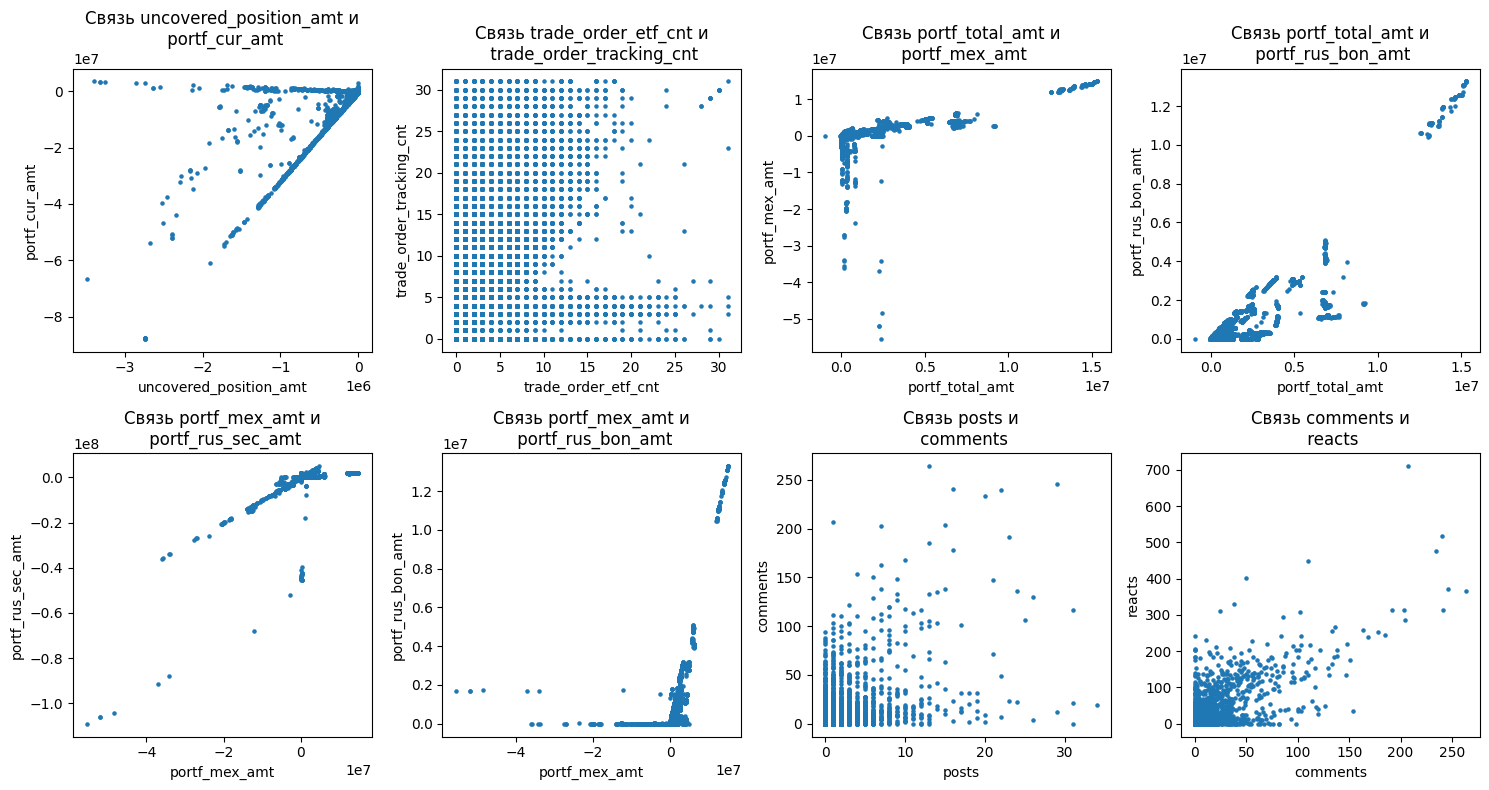

In [175]:
plt.figure(figsize = (15, 8))

for i in range(1, len(related)):
  plt.subplot(2, 4, i)
  plt.scatter(df[related[i][0]], df[related[i][1]], s = 5)
  plt.xlabel(related[i][0])
  plt.ylabel(related[i][1])
  plt.title(f'Связь {related[i][0]} и\n {related[i][1]}')

plt.tight_layout()

Посмотрим на связь флага срочного рынка и флага квал. инвестора с помощью таблицы сопряженности:

In [249]:
crosstab = pd.crosstab(index = df['forts_flg'], columns = df['qualified_investor_flg'], values = df['id'], aggfunc="count")
crosstab.index = ['НЕ подключен срочный рынок','Подключен срочный рынок']
crosstab.columns = ['НЕ квал. инвестор','Квал. инвестор']
round(crosstab/len(df)*100, 3)

,НЕ квал. инвестор,Квал. инвестор
НЕ подключен срочный рынок,46.995,0.005
Подключен срочный рынок,24.326,28.675


Как оказалось почти у всех квал. инвесторов включен срочный рынок. А у большей части не квал. инвесторов он не подключен.

##### Сохраним результат

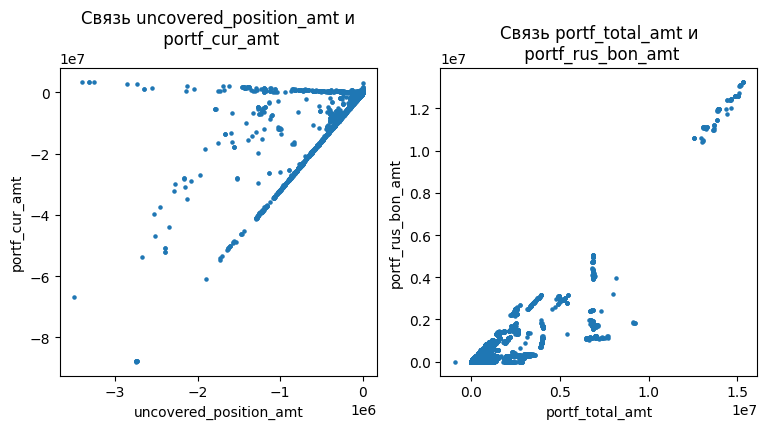

In [186]:
fig = plt.figure(figsize = (9, 4))

for i in [1, 4]:
  plt.subplot(1, 2, (i+1)%2+1)
  plt.scatter(df[related[i][0]], df[related[i][1]], s = 5)
  plt.xlabel(related[i][0])
  plt.ylabel(related[i][1])
  plt.title(f'Связь {related[i][0]} и\n {related[i][1]}')

results.append(fig)

## Анализ выбросов

Посмотрим, есть ли выбросы в данных:

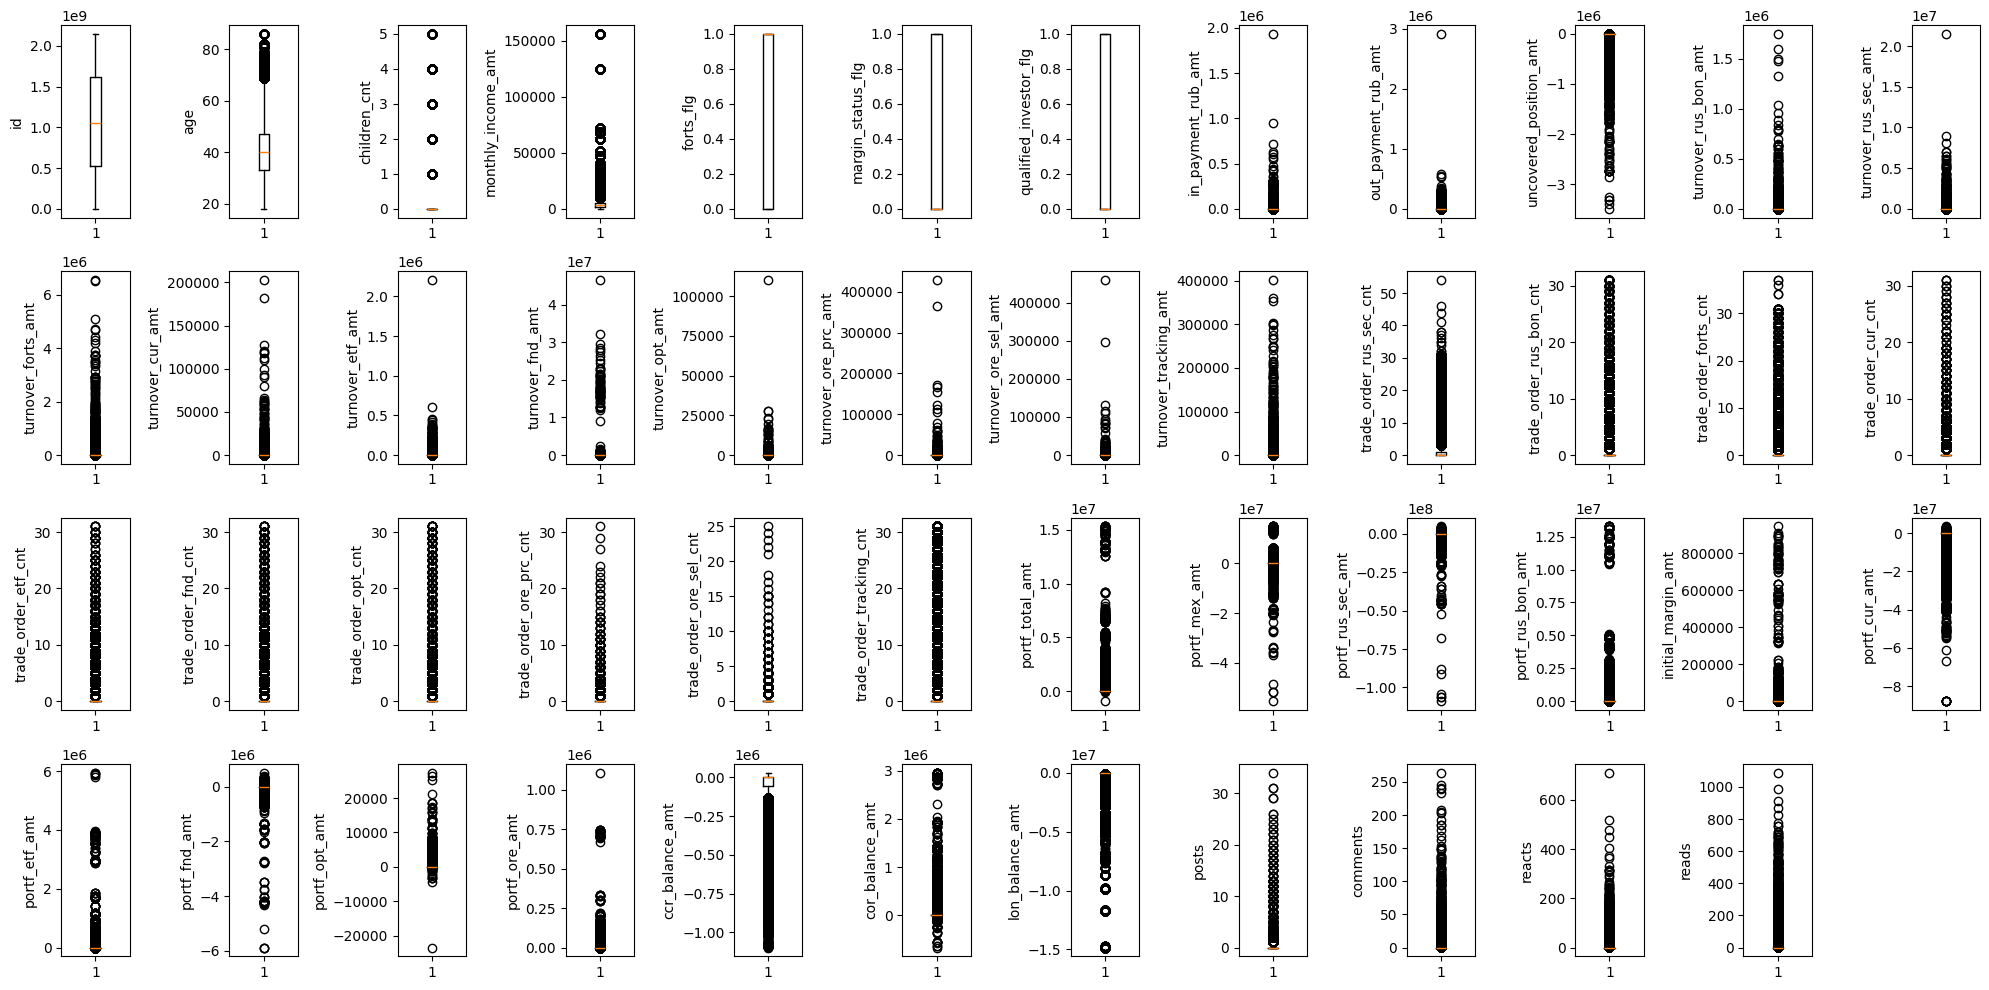

In [ ]:
plt.figure(figsize = (20, 10))

i = 0
for col in df.columns:
  if df[col].dtype != 'object':
    i += 1
    plt.subplot(4, 12, i)
    plt.boxplot(df[col])
    plt.ylabel(col)

plt.tight_layout()

Как можно увидеть, практически во всех переменных есть выбросы(выбросы = кружочки, оранжевая полоска = среднее значение).

Однако я считаю, что некорректно это называть выбросами, потому что большая часть клиентов - люди без экономического образования(только 28% пользователей - квал. инвесторы). Их поведение на фондовом рынке может существенно отличаться от профессионалов. Поэтому поведение квал. инвесторов на фоне большинства пользователей может выглядеть как выбросы. Так что я думаю, что нет смысла без необходимости удалять "выбросы" в данном случае.

## Результаты

Выделим самые интересные с точки зрения анализа результаты:

Возраст половины пользователей находится в диапазоне 33-47 лет:

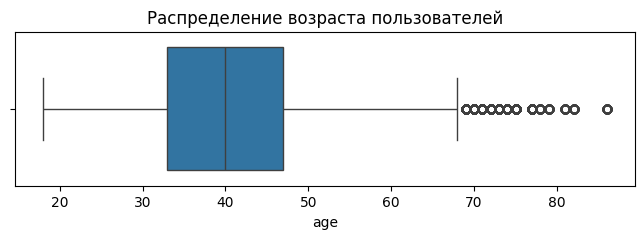

In [215]:
results[0]

28,6% - доля квалифицированных инвесторов:

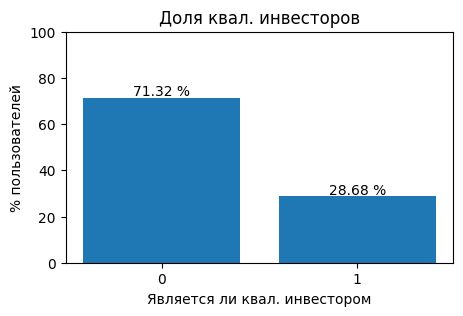

In [223]:
results[1]

Число новых пользователей постепенно растет:

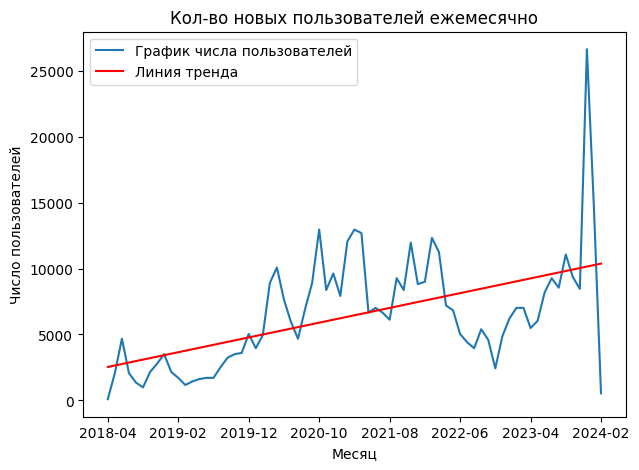

In [224]:
results[2]

*Резкое падание в феврале 2024 года связано с тем, что данные хранят сведения по 01.02.2024.*

1. Менее 1% пользователей написали хотя бы один пост;
2. Около 2% написали хотя бы один комментарий;
3. 3,5% пользователей ставили хотя бы одну реакцию;
4. Почти 31% прочитали хотя бы один пост.

In [231]:
cols = ['posts', 'comments', 'reacts', 'reads']
for col in cols:
  print(f"{col}: {round(len(df[df[col]>0])/len(df)*100, 2)}%")

posts: 0.83%
comments: 1.8%
reacts: 3.56%
reads: 30.87%


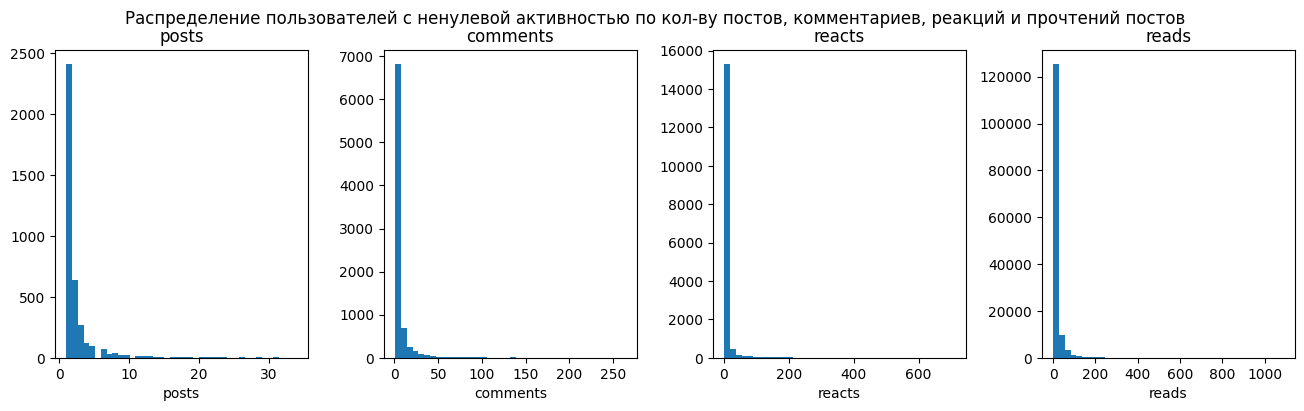

In [232]:
results[3]

Примерно у 90% пользователей в портфеле лежит не более 100 000 тыс. руб:

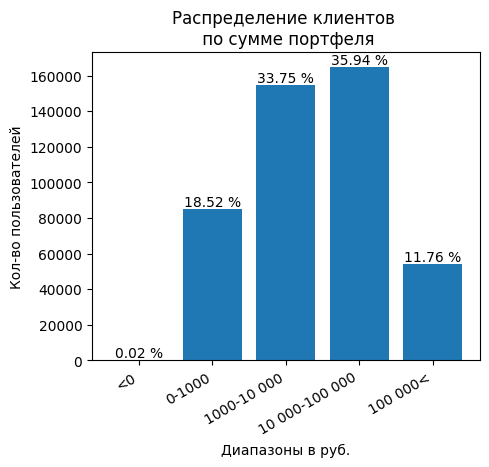

In [234]:
results[4]

Значимые зависимости были обнаружены между:
1. **uncovered_position_amt**(непокрытая позиция в портфеле клиента) и **portf_cur_amt**(объем денежных активов в портфеле)
2. **portf_total_amt**(общий портфель клиента, выраженный в рублях) и **portf_rus_bon_amt**(объем российских облигаций в портфеле)

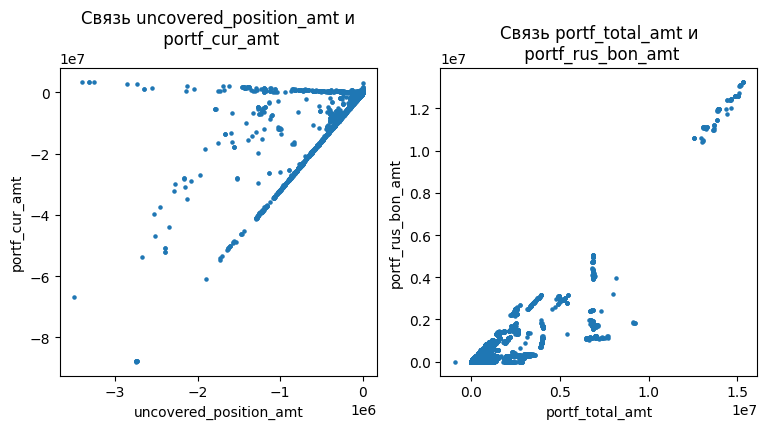

In [236]:
results[5]

Почти у всех квал. инвесторов включен срочный рынок. А у большей части не квал. инвесторов он не подключен:

In [248]:
crosstab = pd.crosstab(index = df['forts_flg'], columns = df['qualified_investor_flg'], values = df['id'], aggfunc="count")
crosstab.index = ['НЕ подключен срочный рынок','Подключен срочный рынок']
crosstab.columns = ['НЕ квал. инвестор','Квал. инвестор']
round(crosstab/len(df)*100, 3)

,НЕ квал. инвестор,Квал. инвестор
НЕ подключен срочный рынок,46.995,0.005
Подключен срочный рынок,24.326,28.675
